In [1]:
#using Revise

In [2]:
# Add PATH
push!(LOAD_PATH, joinpath(@__DIR__, "..", "src"))

#using PyPlot
using Plots
using BenchmarkTools
using DifferentialEquations

using LSM.PhysCon
using LSM.WaterVaporMod
#using LSM.LeafPhotosynthesisMod
using LSM.LeafEnergyWaterBalanceMod

output_dir = joinpath(@__DIR__,"..","output")
mkpath(output_dir)

┌ Info: Recompiling stale cache file /Users/gentine/.julia/compiled/v1.2/LSM.ji for LSM [top-level]
└ @ Base loading.jl:1240


"/Users/gentine/Dropbox/Collaborations_Projects/Optimal_Stomata/LSM-SPAM/test/../output"

In [3]:
# z_L = -1.0:0.001:1.0;
# psim_z = zeros(size(z_L));
# psih_z = zeros(size(z_L));
# for i=1:length(z_L)
#     psim_z[i] = ψ_m(z_L[i]);
#     psih_z[i] = ψ_h(z_L[i]);
# end


In [4]:
# plot(z_L,psih_z,label="psi_h")
# plot!(z_L,psim_z,label="psi_m")


In [5]:

# function lorenz!(du,u,p,t)
#  du[1] = 10.0*(u[2]-u[1]);
#  du[2] = u[1]*(28.0-u[3]) - u[2];
#  du[3] = u[1]*u[2] - (8/3)*u[3];
# end
# u0 = [1.0;0.0;0.0];
# tspan = (0.0,100.0);
# prob = ODEProblem(lorenz!,u0,tspan);
# sol = solve(prob);

# plot(sol,vars=(1,2,3))

# Create a leaf structure
l = leaf_params{Float32}();
# Create a Flux structure
f = fluxes{Float32}();
# Create a meteo structure
met = meteo{Float32}();

#met = meteo();

# initialize some reasonable values
f.Je   = 100; f.gbc  = 100; f.gbv  = 100; f.ceair= 1500; f.eair = 1500; f.APAR = 500; f.H=0;f.LE=0; # leaf should not have eair
l.Kn = 2.44; l.α=0.2; l.ε=0.98; l.LMA=40e-3; l.c_leaf=50/100*4184;l.psi_l=-1e6;l.psi_l50 = -2e6;l.ck=3;met.zscreen = 2.0;
l.height   = 1.0; met.zscreen  = 2.0;


In [6]:

# A diurnal cycle for radiation and Tair
Deltat  = 60;
Samp    = 500; # W/m2 amplitude
Tmean   = 273.15+22;
DeltaT  = 3;
omega   = 2*π/(24*3600);
t       = range(0, stop=24*3600, step=Deltat); # diurnal cycle in seconds
#print(t)
phi_t   = omega*t-π*ones(size(t))/2;
Sdown_t = zeros(size(t));
Tair_t  = zeros(size(t));
zeros_t = zeros(size(t));
for i = 1:length(Sdown_t)
    Sdown_t[i] = Samp*max( sin(phi_t[i]),zeros_t[i] );#max(sin(phase[i]),zeros(size(t[i])));
    Tair_t[i]  = Tmean + DeltaT*sin(phi_t[i]-π/3);
end
#print(typeof(phase[1]));
#print(typeof(Sdown_t[1]));
#print(Sdown_t);
#clf();
#fig = figure("Diurnal cycle", figsize=(10,5));
# plot(t/3600,Sdown_t)
#plot!(t/3600,10*(Tair_t-273.15*ones(size(Tair_t))))
#    title = "Shortwave Incoming radiation (W/m^2)");#,
#    xlabel = "Hours",
#    ylabel = "S_{down} (W/m^2)")
#plot(t/3600,Tair_t-273.15*ones(size(Tair_t)),
#    title = "Temperature (C)",
#    xlabel = "Hours",
#    ylabel = "Temperature (C)")


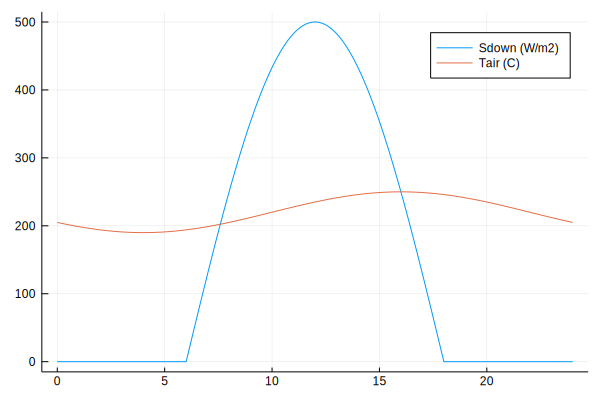

In [7]:
plot(t/3600,Sdown_t,label="Sdown (W/m2)")
plot!(t/3600,10*(Tair_t-273.15*ones(size(Tair_t))),label="Tair (C)")

In [8]:
psi_s      = -0.3e6 ; # soil water potential (Pa)
U          =  1.0;
RH         =  65/100;
eps_air    =  0.75;
tspan      =  (0.0,Deltat);
N          =  length(Sdown_t);
mutable struct parameters_ode
    l::leaf_params;
    met::meteo;
    f::fluxes;
    psi_s;
end

In [9]:
i=1
met.S_down = Sdown_t[i];
met.L_down = eps_air*physcon.σ*(Tair_t[i])^4;
met.T_air  = Tair_t[i];
met.e_air  = RH*SatVap(Tair_t[i])[1];
met.PAR    = 45/100*physcon.Wtoμmole_s*Sdown_t[i];
f.APAR     = met.PAR;
met.U      = U;
met.Ca     = 400.0; #ppm
f.APAR     = met.PAR;

In [10]:
met.U = 2.0;f.H=400.0;
met.L=1e6;
setra!(l,f,met)

Lold=1.0e6
L=-5.507308806094136 ra=20.96723581288221 (s/m), H=222.38959927743753 (W/m2), counter=1
Lold=-5.507308806094136
L=-5.389235685566271 ra=11.861091284836 (s/m), H=357.1870498338271 (W/m2), counter=2
Lold=-5.389235685566271
L=-5.387069472937193 ra=11.767299992993799 (s/m), H=359.43098704434317 (W/m2), counter=3
Lold=-5.387069472937193
L=-5.387028914528567 ra=11.765558974403964 (s/m), H=359.47290711926934 (W/m2), counter=4
Lold=-5.387028914528567
L=-5.387028154859558 ra=11.76552636992112 (s/m), H=359.473692260085 (W/m2), counter=5


14.9278040300895

In [ ]:
# small time stepping
dt = 0.01*60; # in s
T_t    = zeros(size(Sdown_t));
psil_t = zeros(size(Sdown_t));
Rn_t   = zeros(size(Sdown_t));
H_t    = zeros(size(Sdown_t));
LE_t   = zeros(size(Sdown_t));
dummy  = zeros(5,1);


function f_ode!(du,u,p,t,dummy) # p are parameters
    dummy .= LeafEnergyWaterBalance(u[1], u[2], p.met, p.l, p.f, p.psi_s);
    du    .= dummy[1:2];
    #println("du_inside = $(du), u_inside = $(u)")
end

let
    for i=1:N
        met.S_down = Sdown_t[i];
        met.L_down = eps_air*physcon.σ*(Tair_t[i])^4;
        met.T_air  = Tair_t[i];
        met.e_air  = RH*SatVap(Tair_t[i])[1];
        met.PAR    = 45/100*physcon.Wtoμmole_s*Sdown_t[i];
        f.APAR     = met.PAR;
        met.U      = U;
        met.Ca     = 400.0; #ppm
        f.APAR     = met.PAR;
        for j=1:trunc(Deltat/dt)
            u    = [l.T;l.psi_l];
            p    = parameters_ode(l,met,f,psi_s);
            #(p.met, p.l,  p.psi_s, p.U)    = [l;met;psi_s;U];
            #prob = ODEProblem(f_ode!,u0,tspan,p);
            du   = zeros(size(u));
            f_ode!(du,u,p,t,dummy);
            #println("du_outside = $(du), u_outside = $(u)")
            (l.T,l.psi_l) = du*dt+u;
            T_t[i]  = l.T; psil_t[i]=l.psi_l;
            Rn_t[i] = dummy[3]; H_t[i] = dummy[4]; LE_t[i] = dummy[5];
        end
    end

#     l.T        = Tair_t[1]; # initialize temperature of the leaf
#     l.psi_l    = psi_s;

#     for i=1:N
#         met.S_down = Sdown_t[i];
#         met.L_down = eps_air*physcon.σ*(Tair_t[i])^4;
#         met.T_air  = Tair_t[i];
#         met.ea_air = RH*SatVap(Tair_t[i])[1];
#         u0   = [l.T;l.psi_l];
#         p    = parameters_ode(l,met,psi_s);
#         #(p.met, p.l,  p.psi_s, p.U)    = [l;met;psi_s;U];
#         prob = ODEProblem(f_ode!,u0,tspan,p);
#         sol  = solve(prob);
#         (l.T,l.psi_l) = sol[:,end];
#         T_t[i] = l.T; psil_t[i]=l.psi_l;
#         #print((l.T,l.psi_l) )
#         #dT_dt,dH2Ol_dt = LeafEnergyWaterBalance(met, l, psi_s);
#         #l.T        = l.T + Deltat*dT_dt;
#     end

   
end


Lold=-5.387028
L=-1.9113399397980322 ra=23.531051618873317 (s/m), H=191.6265003001978 (W/m2), counter=1
Lold=-1.9113399397980322
L=-1.840167652832018 ra=14.79316405323505 (s/m), H=278.53980107953566 (W/m2), counter=2
Lold=-1.840167652832018
L=-1.8364847564615063 ra=14.500232736977653 (s/m), H=282.84042541827756 (W/m2), counter=3
Lold=-1.8364847564615063
L=-1.8362882159495666 ra=14.484851016213193 (s/m), H=283.0699224607818 (W/m2), counter=4
Lold=-1.8362882159495666
L=-1.8362777104242023 ra=14.484029529417294 (s/m), H=283.0821896149069 (W/m2), counter=5
Lold=-1.8362777104242023
L=-1.8362771488320628 ra=14.483985617331511 (s/m), H=283.0828453782362 (W/m2), counter=6
Sdown= 0.0W/m2, Rn=-122.882965W/m2, SEB=-406.084W/m2, H= 283.08286W /m2, LE= 0.11820681W /m2, dT_dt=-17470.154 (K/hr), ra=18.956121 (s/m) 
Lold=-1.8362771
L=-5.202643808916444 ra=14.483983179780658 (s/m), H=99.91680135434116 (W/m2), counter=1
Lold=-5.202643808916444
L=-5.410973226727576 ra=23.229124841615892 (s/m), H=68.37359

L=0.7981960689474845 ra=320.50249905605983 (s/m), H=-9.613942939115619 (W/m2), counter=18
Lold=0.7981960689474845
L=0.7975742241823102 ra=320.7920911057993 (s/m), H=-9.605383370585827 (W/m2), counter=19
Sdown= 0.0W/m2, Rn=-82.41919W/m2, SEB=-72.817375W/m2, H= -9.605383W /m2, LE= 0.0035715627W /m2, dT_dt=-3132.6787 (K/hr), ra=325.26422 (s/m) 
Lold=0.7975742
L=0.6646493133765928 ra=321.0086109747585 (s/m), H=-11.511927141238465 (W/m2), counter=1
Lold=0.6646493133765928
L=0.579177995025465 ra=376.0418918217223 (s/m), H=-9.846971125936685 (W/m2), counter=2
Lold=0.579177995025465
L=0.5212214230204426 ra=423.7972388417436 (s/m), H=-8.748957700534937 (W/m2), counter=3
Lold=0.5212214230204426
L=0.48049303020640705 ra=464.31316871219417 (s/m), H=-7.992807383736796 (W/m2), counter=4
Lold=0.48049303020640705
L=0.4511415546645547 ra=498.05974792222503 (s/m), H=-7.456065504983304 (W/m2), counter=5
Lold=0.4511415546645547
L=0.4295979704398786 ra=525.7556433364788 (s/m), H=-7.066605694515088 (W/m2), 

L=0.04951608344580096 ra=2550.2582441575337 (s/m), H=-2.4226227540090255 (W/m2), counter=7
Lold=0.04951608344580096
L=0.048957117079108166 ra=2572.3295652548322 (s/m), H=-2.4018720362971235 (W/m2), counter=8
Lold=0.048957117079108166
L=0.048552039683982764 ra=2588.5501955432455 (s/m), H=-2.386847145139189 (W/m2), counter=9
Lold=0.048552039683982764
L=0.04825773937325484 ra=2600.456221621394 (s/m), H=-2.375937876071605 (W/m2), counter=10
Lold=0.04825773937325484
L=0.04804352445306254 ra=2609.1874451298304 (s/m), H=-2.3680007886298156 (W/m2), counter=11
Lold=0.04804352445306254
L=0.04788738982053862 ra=2615.5862640298556 (s/m), H=-2.362217555629495 (W/m2), counter=12
Lold=0.04788738982053862
L=0.04777347475766267 ra=2620.2735164071623 (s/m), H=-2.35799912408609 (W/m2), counter=13
Lold=0.04777347475766267
L=0.047690302292523225 ra=2623.705827774167 (s/m), H=-2.3549196571288737 (W/m2), counter=14
Lold=0.047690302292523225
L=0.047629543428207605 ra=2626.218555943266 (s/m), H=-2.352670334174

L=0.015675657767490372 ra=4487.952231529881 (s/m), H=-1.8551782657035571 (W/m2), counter=17
Lold=0.015675657767490372
L=0.01567050518223155 ra=4488.806619019178 (s/m), H=-1.8548255074646258 (W/m2), counter=18
Lold=0.01567050518223155
L=0.015666722162628904 ra=4489.434142075951 (s/m), H=-1.8545665021137765 (W/m2), counter=19
Sdown= 0.0W/m2, Rn=-59.01602W/m2, SEB=-57.161465W/m2, H= -1.8545665W /m2, LE= 7.445485e-6W /m2, dT_dt=-2459.145 (K/hr), ra=4493.9062 (s/m) 
Lold=0.015666721
L=0.014796259088650223 ra=4489.895124780622 (s/m), H=-1.9631209058515806 (W/m2), counter=1
Lold=0.014796259088650223
L=0.014187764224021671 ra=4599.751441306583 (s/m), H=-1.9162810363289478 (W/m2), counter=2
Lold=0.014187764224021671
L=0.013756535349458652 ra=4681.394563490642 (s/m), H=-1.8828931538254807 (W/m2), counter=3
Lold=0.013756535349458652
L=0.013447848503117714 ra=4741.916027186759 (s/m), H=-1.858884276814991 (W/m2), counter=4
Lold=0.013447848503117714
L=0.013225246876137834 ra=4786.6961829741795 (s/m)

L=0.0065485046456584565 ra=6302.742601389611 (s/m), H=-1.6816282728095886 (W/m2), counter=4
Lold=0.0065485046456584565
L=0.006469316201013907 ra=6341.488948537148 (s/m), H=-1.671360804735979 (W/m2), counter=5
Lold=0.006469316201013907
L=0.00641135873696178 ra=6370.253422373717 (s/m), H=-1.6638191758926033 (W/m2), counter=6
Lold=0.00641135873696178
L=0.006368821136945312 ra=6391.588427682349 (s/m), H=-1.6582692611291188 (W/m2), counter=7
Lold=0.006368821136945312
L=0.006337536182193962 ra=6407.402342024589 (s/m), H=-1.6541793919119456 (W/m2), counter=8
Lold=0.006337536182193962
L=0.006314491923728951 ra=6419.1181105941705 (s/m), H=-1.6511623901754755 (W/m2), counter=9
Lold=0.006314491923728951
L=0.006297498477824065 ra=6427.794568500148 (s/m), H=-1.6489351440688476 (W/m2), counter=10
Lold=0.006297498477824065
L=0.00628495656794156 ra=6434.218423185102 (s/m), H=-1.6472900083610327 (W/m2), counter=11
Lold=0.00628495656794156
L=0.006275694355030698 ra=6438.973539922049 (s/m), H=-1.64607434

L=0.00347756843447185 ra=7925.763048408108 (s/m), H=-1.5756661725431576 (W/m2), counter=3
Lold=0.00347756843447185
L=0.003437553983446863 ra=7969.51728539619 (s/m), H=-1.5670203031439636 (W/m2), counter=4
Lold=0.003437553983446863
L=0.0034082426355949713 ra=8002.019323538733 (s/m), H=-1.5606590456667533 (W/m2), counter=5
Lold=0.0034082426355949713
L=0.003386715868431625 ra=8026.137721234582 (s/m), H=-1.5559719053124854 (W/m2), counter=6
Lold=0.003386715868431625
L=0.003370875938724466 ra=8044.021113669733 (s/m), H=-1.552514605251748 (W/m2), counter=7
Lold=0.003370875938724466
L=0.003359204008845363 ra=8057.273730518354 (s/m), H=-1.549962443281367 (W/m2), counter=8
Lold=0.003359204008845363
L=0.0033505943288654537 ra=8067.09049039977 (s/m), H=-1.5480773548746656 (W/m2), counter=9
Lold=0.0033505943288654537
L=0.0033442385631753517 ra=8074.35987120383 (s/m), H=-1.5466843857181396 (W/m2), counter=10
Lold=0.0033442385631753517
L=0.00333954397278932 ra=8079.74163922534 (s/m), H=-1.5456547374

Lold=0.002300463601225912
L=0.0022971103816619813 ra=9200.196345263561 (s/m), H=-1.4967172539590103 (W/m2), counter=10
Lold=0.0022971103816619813
L=0.002294637536433185 ra=9204.810807019467 (s/m), H=-1.4959672993131856 (W/m2), counter=11
Lold=0.002294637536433185
L=0.0022928133380373437 ra=9208.219366193443 (s/m), H=-1.4954138136069886 (W/m2), counter=12
Lold=0.0022928133380373437
L=0.0022914673205109 ra=9210.736891313569 (s/m), H=-1.4950052779102292 (W/m2), counter=13
Lold=0.0022914673205109
L=0.0022904739625207934 ra=9212.596160240331 (s/m), H=-1.494703705135759 (W/m2), counter=14
Lold=0.0022904739625207934
L=0.0022897407712317267 ra=9213.96920619616 (s/m), H=-1.494481075647614 (W/m2), counter=15
Lold=0.0022897407712317267
L=0.0022891995554257085 ra=9214.98313877307 (s/m), H=-1.4943167163657451 (W/m2), counter=16
Lold=0.0022891995554257085
L=0.002288800020809991 ra=9215.731858289753 (s/m), H=-1.4941953715353762 (W/m2), counter=17
Lold=0.002288800020809991
L=0.0022885050622052467 ra=9

L=0.0015983172863298946 ra=10417.223323572567 (s/m), H=-1.4526108566058848 (W/m2), counter=18
Lold=0.0015983172863298946
L=0.0015982081440982896 ra=10417.550954300663 (s/m), H=-1.4525651917720548 (W/m2), counter=19
Sdown= 0.0W/m2, Rn=-30.020752W/m2, SEB=-28.568195W/m2, H= -1.4525652W /m2, LE= 7.4681293e-6W /m2, dT_dt=-1229.0332 (K/hr), ra=10422.023 (s/m) 
Lold=0.0015982081
L=0.0015727516871180771 ra=10417.79224559987 (s/m), H=-1.4759679059379283 (W/m2), counter=1
Lold=0.0015727516871180771
L=0.001554273552047338 ra=10474.641550209988 (s/m), H=-1.4679607641516719 (W/m2), counter=2
Lold=0.001554273552047338
L=0.0015408131411859898 ra=10516.666294563616 (s/m), H=-1.4620972659910847 (W/m2), counter=3
Lold=0.0015408131411859898
L=0.0015309822878112557 ra=10547.692923394543 (s/m), H=-1.4577982478340075 (W/m2), counter=4
Lold=0.0015309822878112557
L=0.0015237884994097047 ra=10570.578293184046 (s/m), H=-1.4546434399960948 (W/m2), counter=5
Lold=0.0015237884994097047
L=0.0015185169602688355 ra=

L=0.001276950928420503 ra=11238.150158990233 (s/m), H=-1.4289901642351457 (W/m2), counter=17
Lold=0.001276950928420503
L=0.0012768581039430018 ra=11238.52494765466 (s/m), H=-1.42894252842139 (W/m2), counter=18
Lold=0.0012768581039430018
L=0.001276789937953316 ra=11238.80020005346 (s/m), H=-1.4289075457360167 (W/m2), counter=19
Sdown= 0.0W/m2, Rn=-26.205078W/m2, SEB=-24.776178W/m2, H= -1.4289075W /m2, LE= 7.4713184e-6W /m2, dT_dt=-1065.8967 (K/hr), ra=11243.272 (s/m) 
Lold=0.0012767899
L=0.0012601243390688549 ra=11239.002368267666 (s/m), H=-1.4477225553819464 (W/m2), counter=1
Lold=0.0012601243390688549
L=0.001248024719479546 ra=11288.854300720719 (s/m), H=-1.4413318991438266 (W/m2), counter=2
Lold=0.001248024719479546
L=0.001239214576933634 ra=11325.593433505084 (s/m), H=-1.4366582029763728 (W/m2), counter=3
Lold=0.001239214576933634
L=0.0012327859302414387 ra=11352.639901673017 (s/m), H=-1.4332368639752022 (W/m2), counter=4
Lold=0.0012327859302414387
L=0.0012280876855797166 ra=11372.5

L=0.0010430042017051922 ra=11997.491161100621 (s/m), H=-1.4209091293366722 (W/m2), counter=2
Lold=0.0010430042017051922
L=0.0010369319012913734 ra=12029.60428270949 (s/m), H=-1.4171174110462044 (W/m2), counter=3
Lold=0.0010369319012913734
L=0.0010325054316323624 ra=12053.185539895272 (s/m), H=-1.4143459432345695 (W/m2), counter=4
Lold=0.0010325054316323624
L=0.0010292745371866707 ra=12070.49017476628 (s/m), H=-1.412319043315616 (W/m2), counter=5
Lold=0.0010292745371866707
L=0.0010269140638841602 ra=12083.182641093434 (s/m), H=-1.410836058217918 (W/m2), counter=6
Lold=0.0010269140638841602
L=0.0010251883191689233 ra=12092.488881005771 (s/m), H=-1.4097506964633135 (W/m2), counter=7
Lold=0.0010251883191689233
L=0.001023925984187294 ra=12099.310517905444 (s/m), H=-1.4089561673772126 (W/m2), counter=8
Lold=0.001023925984187294
L=0.0010230022770718642 ra=12104.3099365597 (s/m), H=-1.4083744439880204 (W/m2), counter=9
Lold=0.0010230022770718642
L=0.0010223261748807746 ra=12107.973378118731 (s

Lold=0.000886431160436633
L=0.0008855312648470986 ra=12703.107604653726 (s/m), H=-1.395069970245631 (W/m2), counter=8
Lold=0.0008855312648470986
L=0.000884873829935685 ra=12707.423515820952 (s/m), H=-1.3945963195621625 (W/m2), counter=9
Lold=0.000884873829935685
L=0.000884393420847153 ra=12710.580239231618 (s/m), H=-1.394250087810968 (W/m2), counter=10
Lold=0.000884393420847153
L=0.0008840423124714707 ra=12712.888915670685 (s/m), H=-1.3939969792993179 (W/m2), counter=11
Lold=0.0008840423124714707
L=0.0008837856729943487 ra=12714.57726454178 (s/m), H=-1.3938119377013019 (W/m2), counter=12
Lold=0.0008837856729943487
L=0.000883598068182406 ra=12715.81190715552 (s/m), H=-1.3936766530167781 (W/m2), counter=13
Lold=0.000883598068182406
L=0.0008834609192453867 ra=12716.71473651162 (s/m), H=-1.3935777430480882 (W/m2), counter=14
Lold=0.0008834609192453867
L=0.0008833606514738526 ra=12717.3749119473 (s/m), H=-1.3935054260496047 (W/m2), counter=15
Lold=0.0008833606514738526
L=0.00088328734451073

Lold=0.0007831405953686811
L=0.0007830033503967836 ra=13239.994448715564 (s/m), H=-1.382778089705946 (W/m2), counter=13
Lold=0.0007830033503967836
L=0.000782903169472353 ra=13240.769115483121 (s/m), H=-1.3826972159632436 (W/m2), counter=14
Lold=0.000782903169472353
L=0.0007828300403192073 ra=13241.334690777026 (s/m), H=-1.3826381769485176 (W/m2), counter=15
Lold=0.0007828300403192073
L=0.000782776656652068 ra=13241.747604569335 (s/m), H=-1.3825950770766888 (W/m2), counter=16
Lold=0.000782776656652068
L=0.0007827376862146914 ra=13242.049060318852 (s/m), H=-1.3825636128734415 (W/m2), counter=17
Lold=0.0007827376862146914
L=0.0007827092371011477 ra=13242.269142187512 (s/m), H=-1.3825406429084461 (W/m2), counter=18
Lold=0.0007827092371011477
L=0.000782688468511635 ra=13242.429815005933 (s/m), H=-1.3825238739535237 (W/m2), counter=19
Sdown= 0.0W/m2, Rn=-17.079987W/m2, SEB=-15.697471W/m2, H= -1.3825239W /m2, LE= 7.47917e-6W /m2, dT_dt=-675.3214 (K/hr), ra=13246.902 (s/m) 
Lold=0.0007826885
L

Lold=0.0007241231
L=0.0007194592170163406 ra=13590.67585674764 (s/m), H=-1.38462254677949 (W/m2), counter=1
Lold=0.0007194592170163406
L=0.0007160769337404007 ra=13619.991542265792 (s/m), H=-1.3816432618621968 (W/m2), counter=2
Lold=0.0007160769337404007
L=0.0007136205399432676 ra=13641.409036534915 (s/m), H=-1.379474744031149 (W/m2), counter=3
Lold=0.0007136205399432676
L=0.0007118347030290514 ra=13657.04751030439 (s/m), H=-1.3778956459396645 (W/m2), counter=4
Lold=0.0007118347030290514
L=0.0007105353774783051 ra=13668.461640962165 (s/m), H=-1.376745382127074 (W/m2), counter=5
Lold=0.0007105353774783051
L=0.0007095894964163054 ra=13676.790049524272 (s/m), H=-1.3759072943927042 (W/m2), counter=6
Lold=0.0007095894964163054
L=0.000708900635083697 ra=13682.865617740721 (s/m), H=-1.3752965533722792 (W/m2), counter=7
Lold=0.000708900635083697
L=0.0007083988058678028 ra=13687.297038686018 (s/m), H=-1.3748514306218975 (W/m2), counter=8
Lold=0.0007083988058678028
L=0.0007080331487527598 ra=136

Lold=0.0006515368511870555
L=0.000650803509907578 ra=14077.622073851933 (s/m), H=-1.3682714137579375 (W/m2), counter=6
Lold=0.000650803509907578
L=0.000650269958946973 ra=14082.903528492347 (s/m), H=-1.3677584393346194 (W/m2), counter=7
Lold=0.000650269958946973
L=0.0006498816701701414 ra=14086.751059568329 (s/m), H=-1.3673849804072604 (W/m2), counter=8
Lold=0.0006498816701701414
L=0.0006495990434190394 ra=14089.55370417248 (s/m), H=-1.367113071289127 (W/m2), counter=9
Lold=0.0006495990434190394
L=0.0006493932982772225 ra=14091.59507935778 (s/m), H=-1.366915087648967 (W/m2), counter=10
Lold=0.0006493932982772225
L=0.0006492435064652404 ra=14093.0818876986 (s/m), H=-1.3667709249984747 (W/m2), counter=11
Lold=0.0006492435064652404
L=0.0006491344435093342 ra=14094.164743567999 (s/m), H=-1.366665949181954 (W/m2), counter=12
Lold=0.0006491344435093342
L=0.0006490550310192045 ra=14094.953375414494 (s/m), H=-1.3665895066141218 (W/m2), counter=13
Lold=0.0006490550310192045
L=0.0006489972058851

L=0.0006136693601978318 ra=14360.906168223546 (s/m), H=-1.361821433719888 (W/m2), counter=16
Lold=0.0006136693601978318
L=0.0006136508450548758 ra=14361.10436677037 (s/m), H=-1.3618026449835536 (W/m2), counter=17
Lold=0.0006136508450548758
L=0.0006136373722055971 ra=14361.248594709785 (s/m), H=-1.361788972854389 (W/m2), counter=18
Lold=0.0006136373722055971
L=0.0006136275683984038 ra=14361.353548168023 (s/m), H=-1.3617790239335796 (W/m2), counter=19
Sdown= 0.0W/m2, Rn=-12.091095W/m2, SEB=-10.729323W/m2, H= -1.361779W /m2, LE= 7.483606e-6W /m2, dT_dt=-461.58655 (K/hr), ra=14365.826 (s/m) 
Lold=0.00061362755
L=0.0006107562418620571 ra=14361.43008168429 (s/m), H=-1.368157876049836 (W/m2), counter=1
Lold=0.0006107562418620571
L=0.0006086753511756275 ra=14383.867822379329 (s/m), H=-1.36602431708879 (W/m2), counter=2
Lold=0.0006086753511756275
L=0.0006071657075485348 ra=14400.216274104789 (s/m), H=-1.364473961956628 (W/m2), counter=3
Lold=0.0006071657075485348
L=0.0006060696559825459 ra=1441

L=0.0005728067547315531 ra=14674.569928146162 (s/m), H=-1.3619286944235727 (W/m2), counter=1
Lold=0.0005728067547315531
L=0.0005711362981419368 ra=14694.192188528488 (s/m), H=-1.3601105619134215 (W/m2), counter=2
Lold=0.0005711362981419368
L=0.0005699249573261223 ra=14708.474002616613 (s/m), H=-1.358790306540936 (W/m2), counter=3
Lold=0.0005699249573261223
L=0.0005690459721711096 ra=14718.865163820683 (s/m), H=-1.3578313249710434 (W/m2), counter=4
Lold=0.0005690459721711096
L=0.0005684078508979976 ra=14726.423619377198 (s/m), H=-1.3571346186815212 (W/m2), counter=5
Lold=0.0005684078508979976
L=0.0005679444306335555 ra=14731.920556968984 (s/m), H=-1.3566283832372033 (W/m2), counter=6
Lold=0.0005679444306335555
L=0.0005676077982090091 ra=14735.917698102898 (s/m), H=-1.3562605072736014 (W/m2), counter=7
Lold=0.0005676077982090091
L=0.0005673632208801555 ra=14738.823963140996 (s/m), H=-1.355993155083945 (W/m2), counter=8
Lold=0.0005673632208801555
L=0.0005671855017758705 ra=14740.936915639

L=0.0005382594836033551 ra=14997.853177166182 (s/m), H=-1.3521635635049198 (W/m2), counter=6
Lold=0.0005382594836033551
L=0.0005379865864076441 ra=15001.3346730836 (s/m), H=-1.3518498481555266 (W/m2), counter=7
Lold=0.0005379865864076441
L=0.0005377884470442425 ra=15003.864064892308 (s/m), H=-1.3516220175761227 (W/m2), counter=8
Lold=0.0005377884470442425
L=0.0005376445698869692 ra=15005.701616347707 (s/m), H=-1.3514565514698316 (W/m2), counter=9
Lold=0.0005376445698869692
L=0.0005375400861221782 ra=15007.0365000499 (s/m), H=-1.351336374519698 (W/m2), counter=10
Lold=0.0005375400861221782
L=0.0005374642053329895 ra=15008.006190686958 (s/m), H=-1.3512490885832007 (W/m2), counter=11
Lold=0.0005374642053329895
L=0.0005374090949034723 ra=15008.710579897981 (s/m), H=-1.3511856906150672 (W/m2), counter=12
Lold=0.0005374090949034723
L=0.0005373690682295622 ra=15009.22224373388 (s/m), H=-1.3511396424648925 (W/m2), counter=13
Lold=0.0005373690682295622
L=0.0005373399962102603 ra=15009.593908443

L=0.0005133618640301542 ra=15238.741309487405 (s/m), H=-1.3476026557915075 (W/m2), counter=11
Lold=0.0005133618640301542
L=0.000513316858827808 ra=15239.352958246027 (s/m), H=-1.347548584094513 (W/m2), counter=12
Lold=0.000513316858827808
L=0.0005132841919066322 ra=15239.796971316073 (s/m), H=-1.347509334644136 (W/m2), counter=13
Lold=0.0005132841919066322
L=0.000513260480231251 ra=15240.119289462527 (s/m), H=-1.3474808440995911 (W/m2), counter=14
Lold=0.000513260480231251
L=0.0005132432685821462 ra=15240.3532649614 (s/m), H=-1.3474601631475678 (W/m2), counter=15
Lold=0.0005132432685821462
L=0.0005132307749926645 ra=15240.523110269884 (s/m), H=-1.3474451510217271 (W/m2), counter=16
Lold=0.0005132307749926645
L=0.0005132217060793583 ra=15240.64640228434 (s/m), H=-1.3474342538137702 (W/m2), counter=17
Lold=0.0005132217060793583
L=0.0005132151230522579 ra=15240.73590063872 (s/m), H=-1.3474263435807277 (W/m2), counter=18
Lold=0.0005132151230522579
L=0.0005132103444843845 ra=15240.800867848

L=0.0004933712812595147 ra=15441.702564058722 (s/m), H=-1.3443658996590626 (W/m2), counter=16
Lold=0.0004933712812595147
L=0.0004933638244456675 ra=15441.80943825708 (s/m), H=-1.34435659787163 (W/m2), counter=17
Lold=0.0004933638244456675
L=0.0004933584145803974 ra=15441.886976208913 (s/m), H=-1.344349849442672 (W/m2), counter=18
Lold=0.0004933584145803974
L=0.0004933544897483869 ra=15441.943230411773 (s/m), H=-1.3443449534634204 (W/m2), counter=19
Sdown= 0.0W/m2, Rn=-7.3418274W/m2, SEB=-5.99749W/m2, H= -1.344345W /m2, LE= 7.48793e-6W /m2, dT_dt=-258.01822 (K/hr), ra=15446.415 (s/m) 
Lold=0.0004933545
L=0.0004921364356582847 ra=15441.98379807747 (s/m), H=-1.347660979735537 (W/m2), counter=1
Lold=0.0004921364356582847
L=0.0004912546158110567 ra=15454.670894207811 (s/m), H=-1.3465549737708045 (W/m2), counter=2
Lold=0.0004912546158110567
L=0.000490615872803736 ra=15463.881627794779 (s/m), H=-1.34575315870289 (W/m2), counter=3
Lold=0.000490615872803736
L=0.000490153015008775 ra=15470.56707

Lold=0.00047684502
L=0.000475826507083267 ra=15617.567098639998 (s/m), H=-1.3445809082727962 (W/m2), counter=1
Lold=0.000475826507083267
L=0.0004750892991782576 ra=15628.662442755787 (s/m), H=-1.343626615466469 (W/m2), counter=2
Lold=0.0004750892991782576
L=0.0004745554433006431 ra=15636.713023761991 (s/m), H=-1.3429350454352056 (W/m2), counter=3
Lold=0.0004745554433006431
L=0.0004741687117260164 ra=15642.553266977564 (s/m), H=-1.342433795703318 (W/m2), counter=4
Lold=0.0004741687117260164
L=0.0004738884878506722 ra=15646.789449242202 (s/m), H=-1.342070451559726 (W/m2), counter=5
Lold=0.0004738884878506722
L=0.0004736854016898481 ra=15649.861828513634 (s/m), H=-1.3418070516957947 (W/m2), counter=6
Lold=0.0004736854016898481
L=0.00047353819982576755 ra=15652.089973562963 (s/m), H=-1.3416160940182102 (W/m2), counter=7
Lold=0.00047353819982576755
L=0.00047343149398555587 ra=15653.705779539749 (s/m), H=-1.3414776493463612 (W/m2), counter=8
Lold=0.00047343149398555587
L=0.000473354138084082

L=0.0004605319344424451 ra=15796.475790858243 (s/m), H=-1.3397736298751624 (W/m2), counter=5
Lold=0.0004605319344424451
L=0.0004603613138999642 ra=15799.157717327926 (s/m), H=-1.33954626601036 (W/m2), counter=6
Lold=0.0004603613138999642
L=0.0004602376870898039 ra=15801.101877174871 (s/m), H=-1.3393814955274066 (W/m2), counter=7
Lold=0.0004602376870898039
L=0.0004601481031288744 ra=15802.511157052035 (s/m), H=-1.3392620822684371 (W/m2), counter=8
Lold=0.0004601481031288744
L=0.0004600831837832718 ra=15803.532680089183 (s/m), H=-1.3391755383253061 (W/m2), counter=9
Lold=0.0004600831837832718
L=0.0004600361362291321 ra=15804.273118033061 (s/m), H=-1.3391128150435934 (W/m2), counter=10
Lold=0.0004600361362291321
L=0.0004600020394174104 ra=15804.809805704886 (s/m), H=-1.3390673553357035 (W/m2), counter=11
Lold=0.0004600020394174104
L=0.0004599773278383813 ra=15805.198805257429 (s/m), H=-1.3390344073632892 (W/m2), counter=12
Lold=0.0004599773278383813
L=0.00045995941788423673 ra=15805.48075

Lold=0.0004487724956072369
L=0.0004487667610678325 ra=15935.432066276555 (s/m), H=-1.3371076084959264 (W/m2), counter=16
Lold=0.0004487667610678325
L=0.00044876260619600904 ra=15935.499672280432 (s/m), H=-1.3371019374380817 (W/m2), counter=17
Lold=0.00044876260619600904
L=0.0004487595958392251 ra=15935.548655880193 (s/m), H=-1.3370978285308852 (W/m2), counter=18
Lold=0.0004487595958392251
L=0.00044875741472094616 ra=15935.584146667537 (s/m), H=-1.337094851461429 (W/m2), counter=19
Sdown= 0.0W/m2, Rn=-5.1940002W/m2, SEB=-3.8569129W/m2, H= -1.3370949W /m2, LE= 7.489919e-6W /m2, dT_dt=-165.92838 (K/hr), ra=15940.057 (s/m) 
Lold=0.0004487574
L=0.0004480626961604441 ra=15935.609984994097 (s/m), H=-1.3391610989613902 (W/m2), counter=1
Lold=0.0004480626961604441
L=0.0004475600282663545 ra=15943.808791528007 (s/m), H=-1.3384726534281037 (W/m2), counter=2
Lold=0.0004475600282663545
L=0.00044719618725738215 ra=15949.751692393264 (s/m), H=-1.3379740763505998 (W/m2), counter=3
Lold=0.0004471961872

Sdown= 0.0W/m2, Rn=-4.703766W/m2, SEB=-3.3682828W/m2, H= -1.3354905W /m2, LE= 7.490376e-6W /m2, dT_dt=-144.907 (K/hr), ra=16053.162 (s/m) 
Lold=0.0004392984
L=0.000438708024281543 ra=16048.712605987774 (s/m), H=-1.337281742188246 (W/m2), counter=1
Lold=0.000438708024281543
L=0.0004382809013906299 ra=16055.878666174998 (s/m), H=-1.3366850527653396 (W/m2), counter=2
Lold=0.0004382809013906299
L=0.00043797179293854734 ra=16061.071139443666 (s/m), H=-1.3362530286945606 (W/m2), counter=3
Lold=0.00043797179293854734
L=0.0004377480422662851 ra=16064.833113640252 (s/m), H=-1.3359401994007003 (W/m2), counter=4
Lold=0.0004377480422662851
L=0.000437586052737277 ra=16067.55844609997 (s/m), H=-1.335713664167888 (W/m2), counter=5
Lold=0.000437586052737277
L=0.00043746876311050956 ra=16069.532666962108 (s/m), H=-1.3355496108523657 (W/m2), counter=6
Lold=0.00043746876311050956
L=0.00043738383166224353 ra=16070.96271991092 (s/m), H=-1.335430801832491 (W/m2), counter=7
Lold=0.00043738383166224353
L=0.00

L=0.0004291714802251104 ra=16173.253095297421 (s/m), H=-1.3328060171028608 (W/m2), counter=12
Lold=0.0004291714802251104
L=0.0004291608701575405 ra=16173.436379232953 (s/m), H=-1.3327909173801813 (W/m2), counter=13
Lold=0.0004291608701575405
L=0.0004291531876944496 ra=16173.569094331748 (s/m), H=-1.3327799839503702 (W/m2), counter=14
Lold=0.0004291531876944496
L=0.0004291476249995728 ra=16173.665192462257 (s/m), H=-1.3327720672376957 (W/m2), counter=15
Lold=0.0004291476249995728
L=0.00042914359716384175 ra=16173.734776332569 (s/m), H=-1.3327663348695054 (W/m2), counter=16
Lold=0.00042914359716384175
L=0.0004291406806802848 ra=16173.785161363152 (s/m), H=-1.3327621841460184 (W/m2), counter=17
Lold=0.0004291406806802848
L=0.0004291385689024146 ra=16173.821644650789 (s/m), H=-1.3327591786655408 (W/m2), counter=18
Lold=0.0004291385689024146
L=0.00042913703979637784 ra=16173.848061805702 (s/m), H=-1.3327570024380182 (W/m2), counter=19
Sdown= 0.0W/m2, Rn=-4.2233887W/m2, SEB=-2.890639W/m2, H=

L=0.00042250331030628774 ra=16257.29163976778 (s/m), H=-1.3317033749718499 (W/m2), counter=9
Lold=0.00042250331030628774
L=0.0004224794345754181 ra=16257.712830977724 (s/m), H=-1.331668883803724 (W/m2), counter=10
Lold=0.0004224794345754181
L=0.0004224621510874237 ra=16258.017750413712 (s/m), H=-1.3316439151963453 (W/m2), counter=11
Lold=0.0004224621510874237
L=0.0004224496395219626 ra=16258.238493889143 (s/m), H=-1.3316258399988847 (W/m2), counter=12
Lold=0.0004224496395219626
L=0.0004224405822809326 ra=16258.398298182374 (s/m), H=-1.3316127550070889 (W/m2), counter=13
Lold=0.0004224405822809326
L=0.0004224340256143013 ra=16258.513985943411 (s/m), H=-1.331603282497118 (W/m2), counter=14
Lold=0.0004224340256143013
L=0.0004224292791263447 ra=16258.597736024416 (s/m), H=-1.3315964251274053 (W/m2), counter=15
Lold=0.0004224292791263447
L=0.00042242584304698285 ra=16258.658365277794 (s/m), H=-1.3315914609111341 (W/m2), counter=16
Lold=0.00042242584304698285
L=0.00042242335559279583 ra=1625

L=0.0004166831582613761 ra=16332.625164927154 (s/m), H=-1.3305925239287282 (W/m2), counter=13
Lold=0.0004166831582613761
L=0.00041667754887719284 ra=16332.725975409925 (s/m), H=-1.3305843133608086 (W/m2), counter=14
Lold=0.00041667754887719284
L=0.00041667348892062225 ra=16332.79894120247 (s/m), H=-1.330578370682958 (W/m2), counter=15
Lold=0.00041667348892062225
L=0.0004166705503988613 ra=16332.85175315065 (s/m), H=-1.3305740694622417 (W/m2), counter=16
Lold=0.0004166705503988613
L=0.00041666842354627084 ra=16332.889977891356 (s/m), H=-1.330570956300616 (W/m2), counter=17
Lold=0.00041666842354627084
L=0.00041666688416371143 ra=16332.917644538304 (s/m), H=-1.3305687030375561 (W/m2), counter=18
Lold=0.00041666688416371143
L=0.0004166657699814645 ra=16332.937669340416 (s/m), H=-1.3305670721563276 (W/m2), counter=19
Sdown= 0.0W/m2, Rn=-3.5365906W/m2, SEB=-2.2060308W/m2, H= -1.3305671W /m2, LE= 7.492081e-6W /m2, dT_dt=-94.90572 (K/hr), ra=16337.41 (s/m) 
Lold=0.00041666577
L=0.0004163039411

L=0.00041173405220888275 ra=16397.55051247247 (s/m), H=-1.3297010726580114 (W/m2), counter=14
Lold=0.00041173405220888275
L=0.0004117305694008701 ra=16397.614114923985 (s/m), H=-1.3296959164695417 (W/m2), counter=15
Lold=0.0004117305694008701
L=0.00041172804902932665 ra=16397.6601420166 (s/m), H=-1.3296921851231496 (W/m2), counter=16
Lold=0.00041172804902932665
L=0.00041172622513181636 ra=16397.693450340113 (s/m), H=-1.3296894848810845 (W/m2), counter=17
Lold=0.00041172622513181636
L=0.0004117249052443818 ra=16397.717554482013 (s/m), H=-1.3296875308112541 (W/m2), counter=18
Lold=0.0004117249052443818
L=0.00041172395008951516 ra=16397.734997849824 (s/m), H=-1.3296861167193283 (W/m2), counter=19
Sdown= 0.0W/m2, Rn=-3.2572632W/m2, SEB=-1.9275845W/m2, H= -1.3296862W /m2, LE= 7.4923432e-6W /m2, dT_dt=-82.926674 (K/hr), ra=16402.207 (s/m) 
Lold=0.00041172394
L=0.00041141226205816054 ra=16397.747699848394 (s/m), H=-1.330690214860843 (W/m2), counter=1
Lold=0.00041141226205816054
L=0.0004111868

L=0.00040746980953098596 ra=16454.3428760493 (s/m), H=-1.3289226576486348 (W/m2), counter=18
Lold=0.00040746980953098596
L=0.00040746898797397295 ra=16454.35808996751 (s/m), H=-1.3289214292429496 (W/m2), counter=19
Sdown= 0.0W/m2, Rn=-3.0133362W/m2, SEB=-1.6844223W/m2, H= -1.3289214W /m2, LE= 7.4925724e-6W /m2, dT_dt=-72.46558 (K/hr), ra=16458.83 (s/m) 
Lold=0.000407469
L=0.000407200087039236 ra=16454.36902790961 (s/m), H=-1.3297961915403682 (W/m2), counter=1
Lold=0.000407200087039236
L=0.00040700562886448734 ra=16457.97373280406 (s/m), H=-1.3295050122782779 (W/m2), counter=2
Lold=0.00040700562886448734
L=0.0004068649864044365 ra=16460.58242488896 (s/m), H=-1.3292943680201892 (W/m2), counter=3
Lold=0.0004068649864044365
L=0.00040676325533560946 ra=16462.470199595533 (s/m), H=-1.329141977355644 (W/m2), counter=4
Lold=0.00040676325533560946
L=0.00040668966433669504 ra=16463.83622527779 (s/m), H=-1.3290317266828602 (W/m2), counter=5
Lold=0.00040668966433669504
L=0.0004066364265068172 ra=1

L=0.0004035624350702986 ra=16503.89817311271 (s/m), H=-1.3290183902843427 (W/m2), counter=1
Lold=0.0004035624350702986
L=0.00040339448807756974 ra=16507.049055119718 (s/m), H=-1.3287647746371547 (W/m2), counter=2
Lold=0.00040339448807756974
L=0.0004032730287860173 ra=16509.328975715784 (s/m), H=-1.3285813233435042 (W/m2), counter=3
Lold=0.0004032730287860173
L=0.0004031851811377222 ra=16510.97859923938 (s/m), H=-1.3284486197897751 (W/m2), counter=4
Lold=0.0004031851811377222
L=0.0004031216393961076 ra=16512.172130253806 (s/m), H=-1.3283526230120257 (W/m2), counter=5
Lold=0.0004031216393961076
L=0.00040307567627757585 ra=16513.03564710928 (s/m), H=-1.3282831782207747 (W/m2), counter=6
Lold=0.00040307567627757585
L=0.0004030424275261365 ra=16513.66038726787 (s/m), H=-1.328232940589962 (W/m2), counter=7
Lold=0.0004030424275261365
L=0.0004030183754596872 ra=16514.11237003218 (s/m), H=-1.3281965973793244 (W/m2), counter=8
Lold=0.0004030183754596872
L=0.0004030009759283237 ra=16514.439364098

L=0.00040003993359243674 ra=16554.37961380075 (s/m), H=-1.3277623977429056 (W/m2), counter=5
Lold=0.00040003993359243674
L=0.0004000002291167032 ra=16555.13325801014 (s/m), H=-1.327701969947756 (W/m2), counter=6
Lold=0.0004000002291167032
L=0.00039997151047406606 ra=16555.678444939847 (s/m), H=-1.3276582598524265 (W/m2), counter=7
Lold=0.00039997151047406606
L=0.00039995073752747187 ra=16556.07282881044 (s/m), H=-1.3276266421125236 (W/m2), counter=8
Lold=0.00039995073752747187
L=0.00039993571166693613 ra=16556.35812040579 (s/m), H=-1.3276037712348627 (W/m2), counter=9
Lold=0.00039993571166693613
L=0.00039992484276412857 ra=16556.564494892304 (s/m), H=-1.3275872273703275 (W/m2), counter=10
Lold=0.00039992484276412857
L=0.0003999169807150978 ra=16556.71378155354 (s/m), H=-1.3275752601678783 (W/m2), counter=11
Lold=0.0003999169807150978
L=0.00039991129364657984 ra=16556.821771801202 (s/m), H=-1.3275666035265594 (W/m2), counter=12
Lold=0.00039991129364657984
L=0.00039990717984723397 ra=165

Lold=0.0003978873764494305
L=0.0003978836847789206 ra=16584.794241292228 (s/m), H=-1.3271884078880798 (W/m2), counter=13
Lold=0.0003978836847789206
L=0.000397881014551313 ra=16584.84529307197 (s/m), H=-1.3271843236133312 (W/m2), counter=14
Lold=0.000397881014551313
L=0.00039787908314101357 ra=16584.882219801166 (s/m), H=-1.3271813693949173 (W/m2), counter=15
Lold=0.00039787908314101357
L=0.00039787768612474533 ra=16584.90892958873 (s/m), H=-1.3271792325621867 (W/m2), counter=16
Lold=0.00039787768612474533
L=0.000397876675642095 ra=16584.928249261386 (s/m), H=-1.3271776869566958 (W/m2), counter=17
Lold=0.000397876675642095
L=0.00039787594474438077 ra=16584.942223524115 (s/m), H=-1.3271765689950075 (W/m2), counter=18
Lold=0.00039787594474438077
L=0.0003978754160744669 ra=16584.952331353605 (s/m), H=-1.3271757603548713 (W/m2), counter=19
Sdown= 0.0W/m2, Rn=-2.4514465W/m2, SEB=-1.1242783W/m2, H= -1.3271757W /m2, LE= 7.493102e-6W /m2, dT_dt=-48.367615 (K/hr), ra=16589.424 (s/m) 
Lold=0.0003

L=0.00039549692092254076 ra=16617.971542509382 (s/m), H=-1.3267397186956429 (W/m2), counter=17
Lold=0.00039549692092254076
L=0.0003954962869334503 ra=16617.983761815973 (s/m), H=-1.3267387433981606 (W/m2), counter=18
Lold=0.0003954962869334503
L=0.000395495828397788 ra=16617.992599506215 (s/m), H=-1.326738038009024 (W/m2), counter=19
Sdown= 0.0W/m2, Rn=-2.3094482W/m2, SEB=-0.98271775W/m2, H= -1.326738W /m2, LE= 7.4932364e-6W /m2, dT_dt=-42.27753 (K/hr), ra=16622.465 (s/m) 
Lold=0.00039549582
L=0.00039534479809803856 ra=16617.999068253383 (s/m), H=-1.3272432377211432 (W/m2), counter=1
Lold=0.00039534479809803856
L=0.00039523560477956727 ra=16620.10486460667 (s/m), H=-1.3270751189190932 (W/m2), counter=2
Lold=0.00039523560477956727
L=0.00039515664945337186 ra=16621.628053527093 (s/m), H=-1.3269535398299102 (W/m2), counter=3
Lold=0.00039515664945337186
L=0.00039509955499615173 ra=16622.729786248827 (s/m), H=-1.3268656147453475 (W/m2), counter=4
Lold=0.00039509955499615173
L=0.000395058266

L=0.00039175158418648 ra=16669.895459128933 (s/m), H=-1.3262029625426217 (W/m2), counter=4
Lold=0.00039175158418648
L=0.00039171942065174977 ra=16670.52334026295 (s/m), H=-1.3261530256283212 (W/m2), counter=5
Lold=0.00039171942065174977
L=0.0003916961629693833 ra=16670.977412855776 (s/m), H=-1.3261169144733522 (W/m2), counter=6
Lold=0.0003916961629693833
L=0.0003916793448600848 ra=16671.305786812096 (s/m), H=-1.3260908010134727 (W/m2), counter=7
Lold=0.0003916793448600848
L=0.00039166718317529004 ra=16671.543256899102 (s/m), H=-1.3260719171919797 (W/m2), counter=8
Lold=0.00039166718317529004
L=0.00039165838860676734 ra=16671.714987146523 (s/m), H=-1.3260582613930396 (W/m2), counter=9
Lold=0.00039165838860676734
L=0.00039165202888108446 ra=16671.83917610968 (s/m), H=-1.32604838619957 (W/m2), counter=10
Lold=0.00039165202888108446
L=0.00039164742987020157 ra=16671.92898472338 (s/m), H=-1.3260412449365118 (W/m2), counter=11
Lold=0.00039164742987020157
L=0.0003916441041011514 ra=16671.9939

L=0.0003901503108147425 ra=16692.793029146873 (s/m), H=-1.3258468022218137 (W/m2), counter=5
Lold=0.0003901503108147425
L=0.000390130099370864 ra=16693.18975654562 (s/m), H=-1.325815300820218 (W/m2), counter=6
Lold=0.000390130099370864
L=0.0003901154847910739 ra=16693.47664277485 (s/m), H=-1.3257925220850963 (W/m2), counter=7
Lold=0.0003901154847910739
L=0.00039010491709245873 ra=16693.684098014444 (s/m), H=-1.3257760506494798 (W/m2), counter=8
Lold=0.00039010491709245873
L=0.00039009727560000723 ra=16693.834113844023 (s/m), H=-1.3257641400166829 (W/m2), counter=9
Lold=0.00039009727560000723
L=0.00039009175001046076 ra=16693.942593500866 (s/m), H=-1.3257555273165378 (W/m2), counter=10
Lold=0.00039009175001046076
L=0.0003900877544198835 ra=16694.021037271 (s/m), H=-1.3257492993736475 (W/m2), counter=11
Lold=0.0003900877544198835
L=0.00039008486517247865 ra=16694.0777614015 (s/m), H=-1.3257447958702455 (W/m2), counter=12
Lold=0.00039008486517247865
L=0.00039008277592690593 ra=16694.11877

L=0.0003887323544330152 ra=16713.314930677014 (s/m), H=-1.3254949179909163 (W/m2), counter=11
Lold=0.0003887323544330152
L=0.00038872983933450683 ra=16713.364540142367 (s/m), H=-1.3254909846414356 (W/m2), counter=12
Lold=0.00038872983933450683
L=0.00038872802072784774 ra=16713.400411836305 (s/m), H=-1.3254881405231553 (W/m2), counter=13
Lold=0.00038872802072784774
L=0.00038872670573560536 ra=16713.426349978927 (s/m), H=-1.3254860840026865 (W/m2), counter=14
Lold=0.00038872670573560536
L=0.0003887257548942459 ra=16713.4451053478 (s/m), H=-1.3254845969765168 (W/m2), counter=15
Lold=0.0003887257548942459
L=0.00038872506736168494 ra=16713.458666986262 (s/m), H=-1.32548352173921 (W/m2), counter=16
Lold=0.00038872506736168494
L=0.0003887245702216745 ra=16713.468473137422 (s/m), H=-1.3254827442575765 (W/m2), counter=17
Lold=0.0003887245702216745
L=0.00038872421075027873 ra=16713.475563768785 (s/m), H=-1.3254821820767582 (W/m2), counter=18
Sdown= 0.0W/m2, Rn=-1.8993225W/m2, SEB=-0.5738479W/m2,

L=0.0003875486780301492 ra=16730.249407174044 (s/m), H=-1.325269241056232 (W/m2), counter=12
Lold=0.0003875486780301492
L=0.00038754708910423156 ra=16730.280876578756 (s/m), H=-1.3252667489110495 (W/m2), counter=13
Lold=0.00038754708910423156
L=0.00038754594023757285 ra=16730.30363052676 (s/m), H=-1.3252649469717157 (W/m2), counter=14
Lold=0.00038754594023757285
L=0.0003875451095532654 ra=16730.320082756785 (s/m), H=-1.3252636440834893 (W/m2), counter=15
Lold=0.0003875451095532654
L=0.0003875445089292715 ra=16730.33197852861 (s/m), H=-1.32526270203279 (W/m2), counter=16
Lold=0.0003875445089292715
L=0.0003875440746495405 ra=16730.340579754626 (s/m), H=-1.325262020884801 (W/m2), counter=17
Lold=0.0003875440746495405
L=0.00038754376064451776 ra=16730.346798861374 (s/m), H=-1.3252615283819535 (W/m2), counter=18
Sdown= 0.0W/m2, Rn=-1.8269348W/m2, SEB=-0.50168085W/m2, H= -1.3252615W /m2, LE= 7.4936925e-6W /m2, dT_dt=-21.582827 (K/hr), ra=16734.818 (s/m) 
Lold=0.00038754375
L=0.00038746852712

Lold=0.00038640185257970527
L=0.0003863676036931634 ra=16746.736062402626 (s/m), H=-1.3251640924355186 (W/m2), counter=3
Lold=0.0003863676036931634
L=0.0003863428430241245 ra=16747.228477414705 (s/m), H=-1.3251251393341206 (W/m2), counter=4
Lold=0.0003863428430241245
L=0.00038632494162352195 ra=16747.584511188736 (s/m), H=-1.325096976266483 (W/m2), counter=5
Lold=0.00038632494162352195
L=0.0003863119991301649 ra=16747.84193436412 (s/m), H=-1.3250766142633656 (W/m2), counter=6
Lold=0.0003863119991301649
L=0.0003863026417678131 ra=16748.028058022788 (s/m), H=-1.3250618923947128 (W/m2), counter=7
Lold=0.0003863026417678131
L=0.0003862958763871333 ra=16748.162629712562 (s/m), H=-1.3250512483485428 (W/m2), counter=8
Lold=0.0003862958763871333
L=0.00038629098498450364 ra=16748.259927848456 (s/m), H=-1.325043552587879 (W/m2), counter=9
Lold=0.00038629098498450364
L=0.0003862874484629522 ra=16748.33027627467 (s/m), H=-1.3250379884603798 (W/m2), counter=10
Lold=0.0003862874484629522
L=0.0003862

L=0.00038541716040015967 ra=16760.893434490306 (s/m), H=-1.324867774865647 (W/m2), counter=12
Lold=0.00038541716040015967
L=0.0003854159960797754 ra=16760.91666552132 (s/m), H=-1.3248659390570814 (W/m2), counter=13
Lold=0.0003854159960797754
L=0.00038541515428723876 ra=16760.933461399556 (s/m), H=-1.324864611783079 (W/m2), counter=14
Lold=0.00038541515428723876
L=0.00038541454567884417 ra=16760.94560470131 (s/m), H=-1.324863652174973 (W/m2), counter=15
Lold=0.00038541454567884417
L=0.00038541410566025853 ra=16760.9543842206 (s/m), H=-1.3248629583861227 (W/m2), counter=16
Lold=0.00038541410566025853
L=0.00038541378753052764 ra=16760.96073174829 (s/m), H=-1.3248624567823535 (W/m2), counter=17
Sdown= 0.0W/m2, Rn=-1.6955566W/m2, SEB=-0.37070164W/m2, H= -1.3248625W /m2, LE= 7.4938166e-6W /m2, dT_dt=-15.947968 (K/hr), ra=16765.434 (s/m) 
Lold=0.0003854138
L=0.0003853586316971149 ra=16760.96528022573 (s/m), H=-1.3250509391606873 (W/m2), counter=1
Lold=0.0003853586316971149
L=0.000385318757371

L=0.0003845113377802475 ra=16773.8666513985 (s/m), H=-1.3247262056049405 (W/m2), counter=6
Lold=0.0003845113377802475
L=0.0003845044771387914 ra=16774.003970982994 (s/m), H=-1.3247153636875362 (W/m2), counter=7
Lold=0.0003845044771387914
L=0.0003844995171890663 ra=16774.10324940225 (s/m), H=-1.3247075253792024 (W/m2), counter=8
Lold=0.0003844995171890663
L=0.0003844959313435068 ra=16774.17502490788 (s/m), H=-1.3247018585604458 (W/m2), counter=9
Lold=0.0003844959313435068
L=0.0003844933389128059 ra=16774.22691649685 (s/m), H=-1.3246977616466065 (W/m2), counter=10
Lold=0.0003844933389128059
L=0.0003844914646795111 ra=16774.26443255267 (s/m), H=-1.3246947997170853 (W/m2), counter=11
Lold=0.0003844914646795111
L=0.000384490109674803 ra=16774.291555508247 (s/m), H=-1.3246926583413041 (W/m2), counter=12
Lold=0.000384490109674803
L=0.0003844891300530068 ra=16774.311164559782 (s/m), H=-1.324691110197667 (W/m2), counter=13
Lold=0.0003844891300530068
L=0.0003844884218195784 ra=16774.325341286643

L=0.00038320406609816215 ra=16792.769672604358 (s/m), H=-1.3244942153561297 (W/m2), counter=4
Lold=0.00038320406609816215
L=0.00038319441734837526 ra=16792.963681947513 (s/m), H=-1.32447891752999 (W/m2), counter=5
Lold=0.00038319441734837526
L=0.0003831874420957101 ra=16793.103939225242 (s/m), H=-1.3244678583267722 (W/m2), counter=6
Lold=0.0003831874420957101
L=0.00038318239953285713 ra=16793.205336621253 (s/m), H=-1.3244598633172149 (W/m2), counter=7
Lold=0.00038318239953285713
L=0.00038317875413874876 ra=16793.27864054356 (s/m), H=-1.3244540834896525 (W/m2), counter=8
Lold=0.00038317875413874876
L=0.00038317611878482154 ra=16793.331634569255 (s/m), H=-1.324449905077124 (W/m2), counter=9
Lold=0.00038317611878482154
L=0.00038317421361213396 ra=16793.369945799255 (s/m), H=-1.324446884373352 (W/m2), counter=10
Lold=0.00038317421361213396
L=0.00038317283630619247 ra=16793.397642300297 (s/m), H=-1.3244447006116609 (W/m2), counter=11
Lold=0.00038317283630619247
L=0.0003831718406096836 ra=16

L=0.0003827036205440233 ra=16800.231817266875 (s/m), H=-1.3243543518797365 (W/m2), counter=12
Lold=0.0003827036205440233
L=0.0003827029907279606 ra=16800.244503233345 (s/m), H=-1.3243533521178683 (W/m2), counter=13
Lold=0.0003827029907279606
L=0.0003827025354218333 ra=16800.25367418124 (s/m), H=-1.3243526293702481 (W/m2), counter=14
Lold=0.0003827025354218333
L=0.0003827022062721677 ra=16800.26030404807 (s/m), H=-1.3243521068816215 (W/m2), counter=15
Sdown= 0.0W/m2, Rn=-1.5269775W/m2, SEB=-0.20263289W/m2, H= -1.3243521W /m2, LE= 7.4939767e-6W /m2, dT_dt=-8.717476 (K/hr), ra=16804.732 (s/m) 
Lold=0.00038270222
L=0.0003826719516881156 ra=16800.26496145713 (s/m), H=-1.3244556446930384 (W/m2), counter=1
Lold=0.0003826719516881156
L=0.00038265007481585 ra=16800.70566812056 (s/m), H=-1.3244209115628782 (W/m2), counter=2
Lold=0.00038265007481585
L=0.0003826342603859023 ra=16801.024270781534 (s/m), H=-1.3243958028712657 (W/m2), counter=3
Lold=0.0003826342603859023
L=0.0003826228282474095 ra=16

Sdown= 0.0W/m2, Rn=-1.4953918W/m2, SEB=-0.17114292W/m2, H= -1.3242564W /m2, LE= 7.4940067e-6W /m2, dT_dt=-7.3627453 (K/hr), ra=16812.102 (s/m) 
Lold=0.00038219657
L=0.0003821713876174399 ra=16807.634375380385 (s/m), H=-1.3243426824213294 (W/m2), counter=1
Lold=0.0003821713876174399
L=0.00038215318730890784 ra=16808.001661242815 (s/m), H=-1.3243137507869884 (W/m2), counter=2
Lold=0.00038215318730890784
L=0.00038214003074032624 ra=16808.267179453 (s/m), H=-1.3242928363238404 (W/m2), counter=3
Lold=0.00038214003074032624
L=0.00038213052006834874 ra=16808.45912667589 (s/m), H=-1.3242777173461764 (W/m2), counter=4
Lold=0.00038213052006834874
L=0.00038212364490280884 ra=16808.597887697946 (s/m), H=-1.3242667878651662 (W/m2), counter=5
Lold=0.00038212364490280884
L=0.0003821186748893526 ra=16808.69819944612 (s/m), H=-1.3242588869450014 (W/m2), counter=6
Lold=0.0003821186748893526
L=0.00038211508208358053 ra=16808.77071566214 (s/m), H=-1.3242531753613194 (W/m2), counter=7
Lold=0.00038211508208

L=0.0003816988176688935 ra=16814.884389675728 (s/m), H=-1.3241655973764914 (W/m2), counter=10
Lold=0.0003816988176688935
L=0.0003816979826500244 ra=16814.90126829839 (s/m), H=-1.3241642685462836 (W/m2), counter=11
Lold=0.0003816979826500244
L=0.00038169737902154344 ra=16814.913469753923 (s/m), H=-1.3241633079445219 (W/m2), counter=12
Lold=0.00038169737902154344
L=0.00038169694266311244 ra=16814.92229011086 (s/m), H=-1.3241626135323021 (W/m2), counter=13
Lold=0.00038169694266311244
L=0.0003816966272228134 ra=16814.928666291227 (s/m), H=-1.324162111546544 (W/m2), counter=14
Sdown= 0.0W/m2, Rn=-1.4641113W/m2, SEB=-0.1399567W/m2, H= -1.3241621W /m2, LE= 7.4940363e-6W /m2, dT_dt=-6.0210814 (K/hr), ra=16819.4 (s/m) 
Lold=0.00038169662
L=0.0003816758091122011 ra=16814.933380771414 (s/m), H=-1.3242331562179965 (W/m2), counter=1
Lold=0.0003816758091122011
L=0.00038166076575452644 ra=16815.237486688337 (s/m), H=-1.3242092136442407 (W/m2), counter=2
Lold=0.00038166076575452644
L=0.000381649891392

L=0.0003812933092869198 ra=16820.779623260867 (s/m), H=-1.3240974789751538 (W/m2), counter=6
Lold=0.0003812933092869198
L=0.00038129078084126654 ra=16820.83080485291 (s/m), H=-1.3240934511477065 (W/m2), counter=7
Lold=0.00038129078084126654
L=0.000381288953082562 ra=16820.8678032304 (s/m), H=-1.3240905395090998 (W/m2), counter=8
Lold=0.000381288953082562
L=0.00038128763183332005 ra=16820.894548760367 (s/m), H=-1.3240884347405164 (W/m2), counter=9
Lold=0.00038128763183332005
L=0.0003812866767283324 ra=16820.91388266079 (s/m), H=-1.3240869132423518 (W/m2), counter=10
Lold=0.0003812866767283324
L=0.00038128598630125473 ra=16820.92785881099 (s/m), H=-1.3240858133791935 (W/m2), counter=11
Lold=0.00038128598630125473
L=0.0003812854872044786 ra=16820.937961930846 (s/m), H=-1.3240850183080721 (W/m2), counter=12
Lold=0.0003812854872044786
L=0.0003812851264166386 ra=16820.945265301674 (s/m), H=-1.3240844435654868 (W/m2), counter=13
Sdown= 0.0W/m2, Rn=-1.4382935W/m2, SEB=-0.11421655W/m2, H= -1.32

L=0.0003804111894401238 ra=16833.75289172208 (s/m), H=-1.3229466990810907 (W/m2), counter=13
Lold=0.0003804111894401238
L=0.0003804109120745695 ra=16833.758523697077 (s/m), H=-1.3229462565878811 (W/m2), counter=14
Sdown= 0.0W/m2, Rn=-1.4466248W/m2, SEB=-0.12368594W/m2, H= -1.3229463W /m2, LE= 7.494664e-6W /m2, dT_dt=-5.321097 (K/hr), ra=16838.23 (s/m) 
Lold=0.0003804109
L=0.0003803926927709648 ra=16833.762770484635 (s/m), H=-1.3230085593906467 (W/m2), counter=1
Lold=0.0003803926927709648
L=0.0003803795319835744 ra=16834.030023286312 (s/m), H=-1.3229875612198596 (W/m2), counter=2
Lold=0.0003803795319835744
L=0.00038037001888368763 ra=16834.22321188687 (s/m), H=-1.322972382721156 (W/m2), counter=3
Lold=0.00038037001888368763
L=0.0003803631424122272 ra=16834.36286121555 (s/m), H=-1.3229614109285621 (W/m2), counter=4
Lold=0.0003803631424122272
L=0.00038035817177928396 ra=16834.46380854945 (s/m), H=-1.322953479938877 (W/m2), counter=5
Lold=0.00038035817177928396
L=0.0003803545787602187 ra=1

Lold=0.00038006714174389347
L=0.00038006284820292594 ra=16838.81142651017 (s/m), H=-1.3228950520093152 (W/m2), counter=5
Lold=0.00038006284820292594
L=0.0003800597446487445 ra=16838.87452251107 (s/m), H=-1.3228900963797074 (W/m2), counter=6
Lold=0.0003800597446487445
L=0.00038005750126192655 ra=16838.92013157527 (s/m), H=-1.3228865142165436 (W/m2), counter=7
Lold=0.00038005750126192655
L=0.00038005587963928493 ra=16838.953100140414 (s/m), H=-1.322883924857811 (W/m2), counter=8
Lold=0.00038005587963928493
L=0.00038005470745467265 ra=16838.9769314886 (s/m), H=-1.3228820531445238 (W/m2), counter=9
Lold=0.00038005470745467265
L=0.0003800538601440477 ra=16838.99415798454 (s/m), H=-1.3228807001794083 (W/m2), counter=10
Lold=0.0003800538601440477
L=0.0003800532476673189 ra=16839.006610156608 (s/m), H=-1.322879722190339 (W/m2), counter=11
Lold=0.0003800532476673189
L=0.00038005280493956175 ra=16839.01561120631 (s/m), H=-1.3228790152520666 (W/m2), counter=12
Lold=0.00038005280493956175
L=0.0003

L=0.00037976309602368865 ra=16843.255347264094 (s/m), H=-1.3228290928078148 (W/m2), counter=7
Lold=0.00037976309602368865
L=0.0003797617918970214 ra=16843.281888502013 (s/m), H=-1.322827008878905 (W/m2), counter=8
Lold=0.0003797617918970214
L=0.0003797608492229699 ra=16843.30107363623 (s/m), H=-1.3228255025306537 (W/m2), counter=9
Lold=0.0003797608492229699
L=0.0003797601678205564 ra=16843.314941460285 (s/m), H=-1.3228244136807508 (W/m2), counter=10
Lold=0.0003797601678205564
L=0.0003797596752754295 ra=16843.32496570524 (s/m), H=-1.3228236266154818 (W/m2), counter=11
Lold=0.0003797596752754295
L=0.0003797593192438162 ra=16843.332211648354 (s/m), H=-1.3228230576924014 (W/m2), counter=12
Sdown= 0.0W/m2, Rn=-1.4055786W/m2, SEB=-0.08276306W/m2, H= -1.322823W /m2, LE= 7.4947025e-6W /m2, dT_dt=-3.5605524 (K/hr), ra=16847.805 (s/m) 
Lold=0.00037975932
L=0.0003797472506986211 ra=16843.33738596286 (s/m), H=-1.3228638057001214 (W/m2), counter=1
Lold=0.0003797472506986211
L=0.0003797385241826359 

L=0.00037933053635079634 ra=16849.616767153486 (s/m), H=-1.3227487251039276 (W/m2), counter=5
Lold=0.00037933053635079634
L=0.0003793289003446147 ra=16849.65011363994 (s/m), H=-1.3227461079980476 (W/m2), counter=6
Lold=0.0003793289003446147
L=0.0003793277177949355 ra=16849.67421751732 (s/m), H=-1.3227442162789818 (W/m2), counter=7
Lold=0.0003793277177949355
L=0.00037932686301509085 ra=16849.69164054009 (s/m), H=-1.3227428488897177 (W/m2), counter=8
Lold=0.00037932686301509085
L=0.00037932624515597563 ra=16849.704234431105 (s/m), H=-1.3227418605009107 (W/m2), counter=9
Lold=0.00037932624515597563
L=0.0003793257985496549 ra=16849.713337676156 (s/m), H=-1.3227411460645284 (W/m2), counter=10
Lold=0.0003793257985496549
L=0.0003793254757296549 ra=16849.71991777547 (s/m), H=-1.3227406296489044 (W/m2), counter=11
Sdown= 0.0W/m2, Rn=-1.3782349W/m2, SEB=-0.055501685W/m2, H= -1.3227407W /m2, LE= 7.494729e-6W /m2, dT_dt=-2.3877397 (K/hr), ra=16854.191 (s/m) 
Lold=0.00037932547
L=0.0003793171649749

Excessive output truncated after 524292 bytes.

-1.32272522958836 (W/m2), counter=2
Lold=0.0003791524235100767
L=0.00037914876134634344 ra=16852.275125411863 (s/m), H=-1.3227193685730105 (W/m2), counter=3
Lold=0.00037914876134634344
L=0.00037914611426483595 ra=16852.329115230787 (s/m), H=-1.322715132100258 (W/m2), counter=4
Lold=0.00037914611426483595
L=0.00037914420089985425 ra=16852.36814052816 (s/m), H=-1.3227120698803803 (W/m2), counter=5
Lold=0.00037914420089985425
L=0.00037914281787808726 ra=16852.396349041206 (s/m), H=-1.3227098564360082 (W/m2), counter=6
Lold=0.00037914281787808726
L=0.00037914181819877164 ra=16852.416738884716 (s/m), H=-1.3227082565057255 (W/m2), counter=7
Lold=0.00037914181819877164
L=0.0003791410956074253 ra=16852.431477184757 (s/m), H=-1.322707100037634 (W/m2), counter=8
Lold=0.0003791410956074253
L=0.0003791405733013643 ra=16852.442130401243 (s/m), H=-1.3227062641144713 (W/m2), counter=9
Lold=0.0003791405733013643
L=0.00037914019576606686 ra=16852.449830814057 (s/m), H=-1.3227056598888431 (W/m2), counte

In [ ]:
plot(t/3600, T_t-273.15*ones(size(T_t)),xlabel = "t (hr)",ylabel = "T (C)",label="T (C)",ylim=0:100)
plot!(t/3600,-psil_t/100000,xlabel = "t (hr)",ylabel = "|psi_l (1000 hPa)|",label="psi_l",ylim=0:100)

In [ ]:
savefig(joinpath(output_dir, "T_psi_t.png"))

In [ ]:
plot(t/3600,  Rn_t,xlabel = "t (hr)",ylabel = "Rn (W/m2)",label="Rn")
plot!(t/3600, H_t,xlabel  = "t (hr)",ylabel = "H (W/m2)" ,label="H")
plot!(t/3600, LE_t,xlabel = "t (hr)",ylabel = "LE (W/m2)",label="LE")